<a href="https://colab.research.google.com/github/cyss93/CP1_team8/blob/%EC%98%A4%EC%B0%BD%EC%98%81/Concentration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

In [2]:
# # 한글 깨짐 방지
# # 아래 코드 실행 후 런타임 재시작 및 코드 실행 해주어야함
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [4]:
# copy 경고 무시
pd.set_option('mode.chained_assignment',  None)

In [5]:
df_customer = pd.read_csv('olist_customers_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')

### 제품/산업/지역 집중도
- 제품별, 산업별, 지역별 집중도가 어떻게 되는지 확인해보고, 판매자들의 다양성이 어떤지 확인하고자 하였습니다.
- 먼저 제품 카테고리 비율이 분기별로 어떤 차이를 보이는지 확인해본 후, GMV와 연관지어 확인해보려 합니다.

In [6]:
df_products['product_category_name'].value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 73, dtype: int64

### 1. 제품군(category) 별
- 판매량 및 수익을 보기 위해선, df_orders와 df_order_items, df_producst를 merge. (pk로 order_id와 products_id를 차례로 사용)
- 해당 병합을 통해 날짜와 카테고리를 모든 주문 건수 별로 구할 수 있습니다.

In [7]:
# df_orders와 df_order_items merge
df_for_cate_temp = pd.merge(df_orders, df_order_items, how = 'inner', on = 'order_id') # 양쪽에 모두 존재하는 값들만 가져오기위해 inner 사용
df_for_cate = pd.merge(df_for_cate_temp, df_products, how = 'inner', on = 'product_id') # 여기도 역시 양쪽에 모두 존재하는 값들만 가져오기

In [11]:
# 데이터셋의 컬럼들
df_for_cate.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [12]:
# 제품 category들을 묶어줄 수 있을지 먼저 살펴보자
df_for_cate['product_category_name'].unique()

array(['utilidades_domesticas', 'perfumaria', 'automotivo', 'pet_shop',
       'papelaria', nan, 'moveis_decoracao', 'moveis_escritorio',
       'ferramentas_jardim', 'informatica_acessorios', 'cama_mesa_banho',
       'brinquedos', 'construcao_ferramentas_construcao', 'telefonia',
       'beleza_saude', 'eletronicos', 'bebes', 'cool_stuff',
       'relogios_presentes', 'climatizacao', 'esporte_lazer',
       'livros_interesse_geral', 'eletroportateis', 'alimentos',
       'malas_acessorios', 'fashion_underwear_e_moda_praia',
       'artigos_de_natal', 'fashion_bolsas_e_acessorios',
       'instrumentos_musicais', 'construcao_ferramentas_iluminacao',
       'livros_tecnicos', 'construcao_ferramentas_jardim',
       'eletrodomesticos', 'market_place', 'agro_industria_e_comercio',
       'artigos_de_festas', 'casa_conforto', 'cds_dvds_musicais',
       'industria_comercio_e_negocios', 'consoles_games', 'moveis_quarto',
       'construcao_ferramentas_seguranca', 'telefonia_fixa', 'bebidas

In [13]:
# 기준 없이 8개의 대분류로 나누어보자(big_product_category_name)
# 이후 회의를 통해 대분류 통일
cate_1 = ['utilidades_domesticas', 'perfumaria', 'automotivo', 'pet_shop',
       'papelaria', 'moveis_decoracao', 'moveis_escritorio',
       'ferramentas_jardim', 'informatica_acessorios', 'cama_mesa_banho']

cate_2 = ['brinquedos', 'construcao_ferramentas_construcao', 'telefonia',
       'beleza_saude', 'eletronicos', 'bebes', 'cool_stuff',
       'relogios_presentes', 'climatizacao', 'esporte_lazer']

cate_3 = ['livros_interesse_geral', 'eletroportateis', 'alimentos',
       'malas_acessorios', 'fashion_underwear_e_moda_praia',
       'artigos_de_natal', 'fashion_bolsas_e_acessorios']

cate_4 = ['instrumentos_musicais', 'construcao_ferramentas_iluminacao',
       'livros_tecnicos', 'construcao_ferramentas_jardim',
       'eletrodomesticos', 'market_place', 'agro_industria_e_comercio']

cate_5 = ['artigos_de_festas', 'casa_conforto', 'cds_dvds_musicais',
       'industria_comercio_e_negocios', 'consoles_games', 'moveis_quarto',
       'construcao_ferramentas_seguranca', 'telefonia_fixa', 'bebidas']

cate_6 = ['moveis_cozinha_area_de_servico_jantar_e_jardim',
       'fashion_calcados', 'casa_construcao', 'audio',
       'eletrodomesticos_2', 'fashion_roupa_masculina', 'cine_foto',]

cate_7 = ['moveis_sala', 'artes', 'alimentos_bebidas',
       'tablets_impressao_imagem', 'fashion_esporte',
       'portateis_cozinha_e_preparadores_de_alimentos', 'la_cuisine',
       'flores', 'pcs', 'casa_conforto_2', 'portateis_casa_forno_e_cafe']
       
cate_8 = ['dvds_blu_ray', 'pc_gamer', 'construcao_ferramentas_ferramentas',
       'fashion_roupa_feminina', 'moveis_colchao_e_estofado',
       'sinalizacao_e_seguranca', 'fraldas_higiene', 'livros_importados',
       'fashion_roupa_infanto_juvenil', 'musica', 'artes_e_artesanato',
       'seguros_e_servicos']

In [14]:
# big_product_category_name 컬럼 생성 (대분류를 위한 컬럼)
df_for_cate['big_product_category_name'] = 'No Category'

In [15]:
# 카테고리별 라벨링하기 위한 함수
# big_product_category_name에 라벨링

def classify_category(df):
  for i in range(len(df['product_category_name'])):
    if df['product_category_name'][i] in cate_1:
      df['big_product_category_name'][i] = 'cate_1'

    elif df['product_category_name'][i] in cate_2:
      df['big_product_category_name'][i] = 'cate_2'

    elif df['product_category_name'][i] in cate_3:
      df['big_product_category_name'][i] = 'cate_3'

    elif df['product_category_name'][i] in cate_4:
      df['big_product_category_name'][i] = 'cate_4'

    elif df['product_category_name'][i] in cate_5:
      df['big_product_category_name'][i] = 'cate_5'

    elif df['product_category_name'][i] in cate_6:
      df['big_product_category_name'][i] = 'cate_6'

    elif df['product_category_name'][i] in cate_7:
      df['big_product_category_name'][i] = 'cate_7'

    elif df['product_category_name'][i] in cate_8:
      df['big_product_category_name'][i] = 'cate_8'

    else:
      df['big_product_category_name'][i] = 'No_category'

In [16]:
classify_category(df_for_cate)

In [17]:
df_for_cate

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,big_product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,cate_1
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,cate_1
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,cate_1
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,87285b34884572647811a353c7ac498a,...,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,cate_1
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,cate_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,1,0df37da38a30a713453b03053d60d3f7,...,18.12,esporte_lazer,53.0,1105.0,1.0,2800.0,28.0,23.0,23.0,cate_2
112646,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,2,0df37da38a30a713453b03053d60d3f7,...,18.12,esporte_lazer,53.0,1105.0,1.0,2800.0,28.0,23.0,23.0,cate_2
112647,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,1,3d2c44374ee42b3003a470f3e937a2ea,...,15.14,instrumentos_musicais,34.0,372.0,2.0,300.0,16.0,6.0,12.0,cate_4
112648,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1,ac35486adb7b02598c182c2ff2e05254,...,13.08,beleza_saude,50.0,1517.0,1.0,1175.0,22.0,13.0,18.0,cate_2


In [18]:
# 분기별로 나누기
## 분기별로 나눈 뒤에 카테고리 별로 나누자 (필터링)
mask_16_4 = (df_for_cate['order_estimated_delivery_date'] > '2016-10-01') & (df_for_cate['order_estimated_delivery_date'] <= '2016-12-31')
mask_17_1 = (df_for_cate['order_estimated_delivery_date'] > '2017-01-01') & (df_for_cate['order_estimated_delivery_date'] <= '2017-03-31')
mask_17_2 = (df_for_cate['order_estimated_delivery_date'] > '2017-04-01') & (df_for_cate['order_estimated_delivery_date'] <= '2017-06-31')
mask_17_3 = (df_for_cate['order_estimated_delivery_date'] > '2017-07-01') & (df_for_cate['order_estimated_delivery_date'] <= '2017-09-31')
mask_17_4 = (df_for_cate['order_estimated_delivery_date'] > '2017-10-01') & (df_for_cate['order_estimated_delivery_date'] <= '2017-12-31')
mask_18_1 = (df_for_cate['order_estimated_delivery_date'] > '2018-01-01') & (df_for_cate['order_estimated_delivery_date'] <= '2018-03-31')
mask_18_2 = (df_for_cate['order_estimated_delivery_date'] > '2018-04-01') & (df_for_cate['order_estimated_delivery_date'] <= '2018-06-31')
mask_18_3 = (df_for_cate['order_estimated_delivery_date'] > '2018-06-01') & (df_for_cate['order_estimated_delivery_date'] <= '2018-06-31')

In [19]:
# 필터 적용
df_16_4_cate = df_for_cate.loc[mask_16_4]
df_17_1_cate = df_for_cate.loc[mask_17_1]
df_17_2_cate = df_for_cate.loc[mask_17_2]
df_17_3_cate = df_for_cate.loc[mask_17_3]
df_17_4_cate = df_for_cate.loc[mask_17_4]
df_18_1_cate = df_for_cate.loc[mask_18_1]
df_18_2_cate = df_for_cate.loc[mask_18_2]
df_18_3_cate = df_for_cate.loc[mask_18_3]

In [57]:
# 17_2분기 데이터
df_17_2_cate

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,big_product_category_name
158,2804b32d150c753fbd49da4d9c0c3158,5d86d96c2e0dcf2821a9f5b082e8bcc9,delivered,2017-04-11 14:17:17,2017-04-11 14:30:07,2017-04-13 09:35:44,2017-04-20 14:45:04,2017-05-09 00:00:00,2,060cb19345d90064d1015407193c233d,...,24.15,automotivo,49.0,608.0,1.0,7150.0,65.0,10.0,65.0,cate_1
161,6a022aedc6fb8597eddd4b1ed70d14f7,97a1a7d434c0aec55e81662dcc0779be,delivered,2017-05-18 12:42:52,2017-05-18 13:10:25,2017-05-19 13:07:24,2017-06-06 05:23:30,2017-05-31 00:00:00,1,060cb19345d90064d1015407193c233d,...,14.41,automotivo,49.0,608.0,1.0,7150.0,65.0,10.0,65.0,cate_1
164,68f990d7575ee4ce6070c8816664910c,5e4fd80186282f6f16f454b24fed62e6,delivered,2017-05-24 14:37:44,2017-05-24 14:45:15,2017-05-26 10:03:31,2017-06-08 06:54:57,2017-06-16 00:00:00,1,060cb19345d90064d1015407193c233d,...,27.36,automotivo,49.0,608.0,1.0,7150.0,65.0,10.0,65.0,cate_1
166,f31cf521d461f5b8b5b1456a0448495e,7d9fd47eeb21776ed93f070d71499e0a,delivered,2017-05-28 15:50:05,2017-05-29 21:45:10,2017-05-31 09:07:45,2017-06-07 11:51:24,2017-06-21 00:00:00,1,060cb19345d90064d1015407193c233d,...,21.27,automotivo,49.0,608.0,1.0,7150.0,65.0,10.0,65.0,cate_1
170,0cbd2aa629e9ecbbcf518a10e247414f,b777e264df0b508f453971fb87c2a0b7,delivered,2017-03-27 20:40:27,2017-03-27 22:15:18,2017-03-28 10:22:55,2017-04-06 15:37:55,2017-04-18 00:00:00,2,060cb19345d90064d1015407193c233d,...,21.88,automotivo,49.0,608.0,1.0,7150.0,65.0,10.0,65.0,cate_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112618,46b4a41ba02248ac63e0d85649595f7e,7289387e125fb55957fab19cf6049956,delivered,2017-05-16 23:24:13,2017-05-16 23:35:21,2017-05-17 09:17:58,2017-05-24 12:59:35,2017-06-08 00:00:00,1,a16485b933e24a0ee5f137fec64c48d2,...,13.82,brinquedos,60.0,999.0,2.0,1094.0,26.0,18.0,29.0,cate_2
112620,67efc48800e617879edb36f04f815c59,6eac56572e999fbdb8f2dfef5403438f,delivered,2017-06-17 15:26:32,2017-06-17 15:42:41,2017-06-19 21:47:25,2017-06-24 08:31:30,2017-06-30 00:00:00,1,926454d19f2417167bf0a9488af66a4a,...,17.48,esporte_lazer,40.0,1397.0,3.0,5000.0,100.0,9.0,23.0,cate_2
112621,67efc48800e617879edb36f04f815c59,6eac56572e999fbdb8f2dfef5403438f,delivered,2017-06-17 15:26:32,2017-06-17 15:42:41,2017-06-19 21:47:25,2017-06-24 08:31:30,2017-06-30 00:00:00,2,926454d19f2417167bf0a9488af66a4a,...,17.48,esporte_lazer,40.0,1397.0,3.0,5000.0,100.0,9.0,23.0,cate_2
112639,9b7fd5b0ef330dcbbb6397e5971faeec,4442f152efb5f70fd55dcd6267d1afa4,delivered,2017-05-17 15:48:44,2017-05-17 16:15:16,2017-05-18 13:30:39,2017-05-29 15:18:32,2017-06-08 00:00:00,1,afb83a05bfcf46258f04ce060671d5b4,...,15.10,telefonia_fixa,49.0,709.0,5.0,150.0,17.0,3.0,12.0,cate_5


#### 1.1 판매'량'

In [21]:
# 대분류로 분류한 데이터를 카테고리별 분포를 알아보기 위한 함수입니다.
# 파이차트로 각 대분류가 차지하는 비율을 시각화 해보았습니다.

def PieChart_category(df): # 원하는 분기 데이터 입력 (ex: df_17_2_cate)
  # 대분류로 분류된 판매자들을 분류별로 갯수 세기
  df_cnt = pd.DataFrame(df['big_product_category_name'].value_counts())

  # 컬럼 명 바꿔주기 (cnt로)
  df_cnt.rename(columns = {'big_product_category_name':'cnt'}, inplace = True)

  # 데이터프레임 인덱스 정리
  df_cnt = df_cnt.reset_index()


  # 그래프 그리기
  # 모든 카테고리 그래프
  labels = df_cnt['index']

  fig = plt.figure(figsize=(7,7)) ## 캔버스 생성
  fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
  ax = fig.add_subplot() ## 프레임 생성

  pie = ax.pie(df_cnt['cnt'], 
              startangle = 90, 
              autopct = '%1.1f%%',
              # explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
              textprops = {'size' : 13})
  plt.axis('equal')
  plt.legend(pie[0],labels, loc='upper left')
  plt.title('전체 카테고리 비율')
  plt.show()

  # 상위 5개 카테고리 그래프
  labels = df_cnt['index'][:5]

  fig = plt.figure(figsize=(7,7)) ## 캔버스 생성
  fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
  ax = fig.add_subplot() ## 프레임 생성

  pie = ax.pie(df_cnt['cnt'][:5], 
              startangle = 90, 
              autopct = '%1.1f%%',
              # explode = [0.05, 0.05, 0.05, 0.05, 0.05],
              textprops = {'size' : 13})
  plt.axis('equal')
  plt.legend(pie[0],labels, loc='upper right')
  plt.title('상위 5개 카테고리 비율')
  plt.show()


[16_4분기]


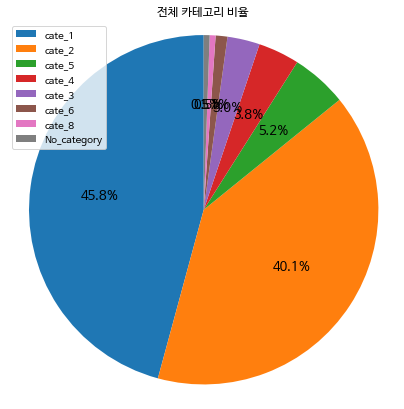

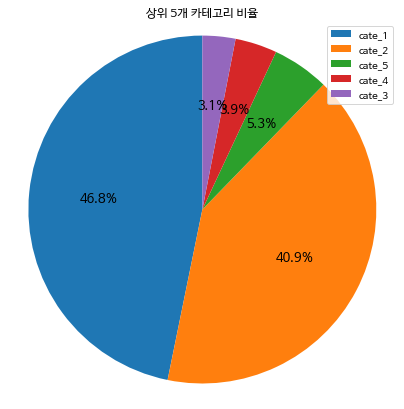


[17_1분기]


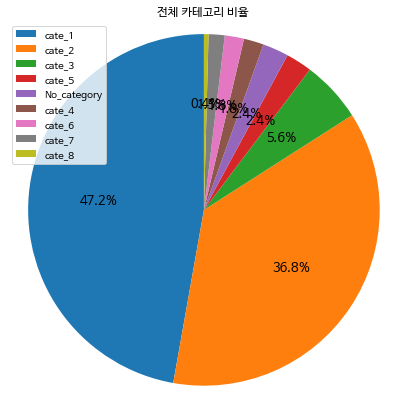

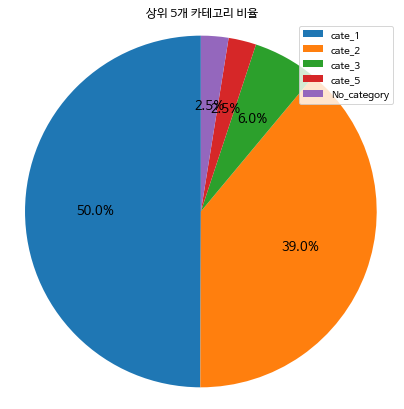


[17_2분기]


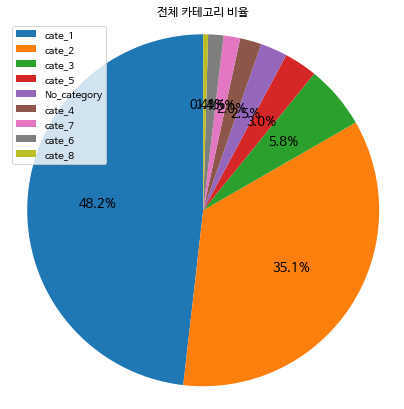

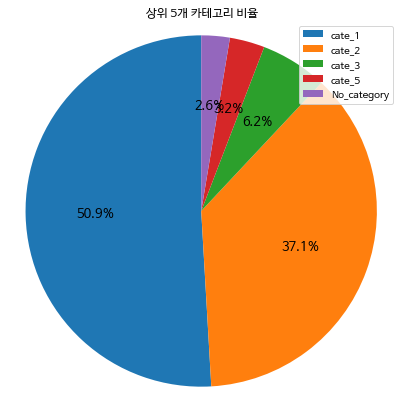


[17_3분기]


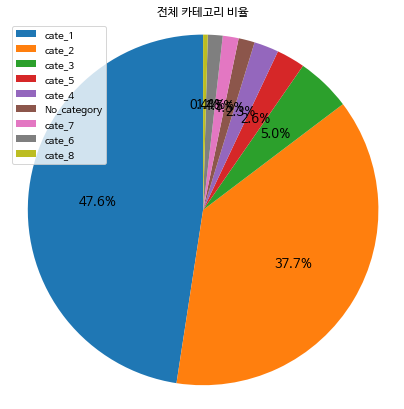

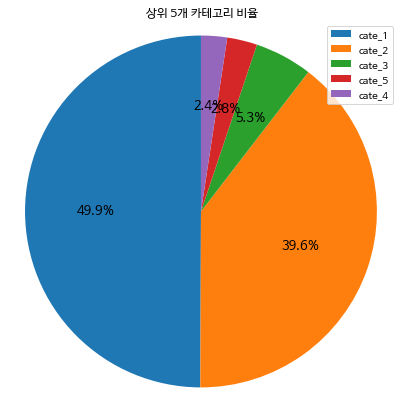


[17_4분기]


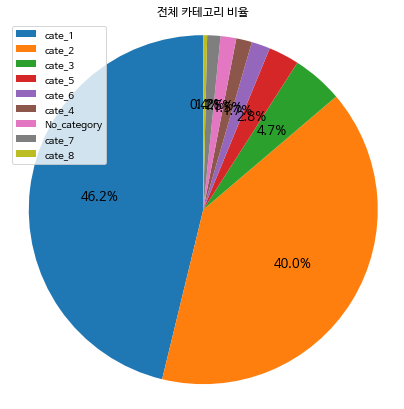

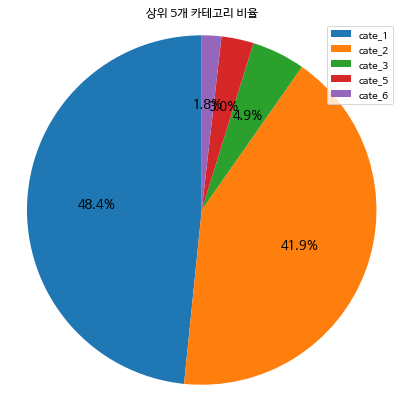


[18_1분기]


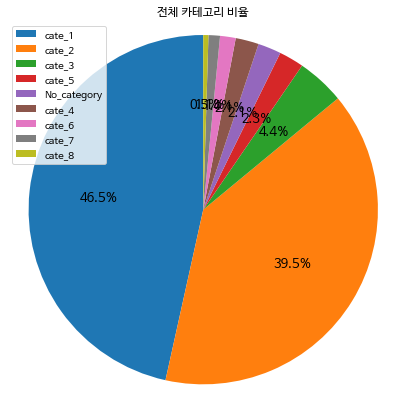

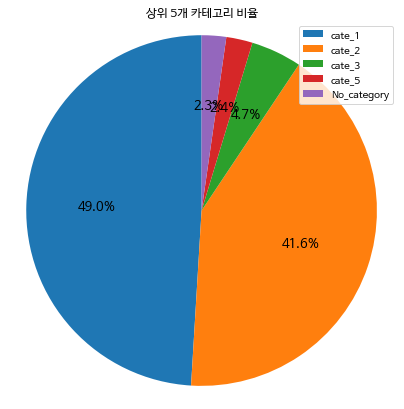


[18_2분기]


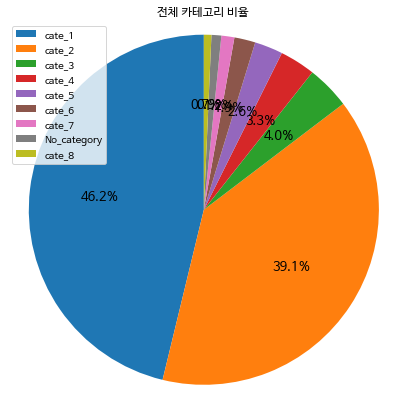

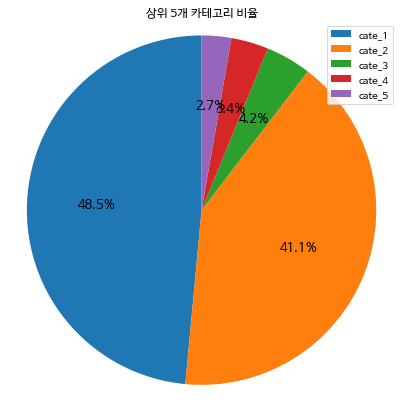


[18_3분기]


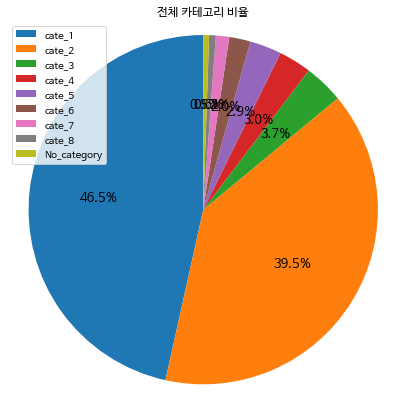

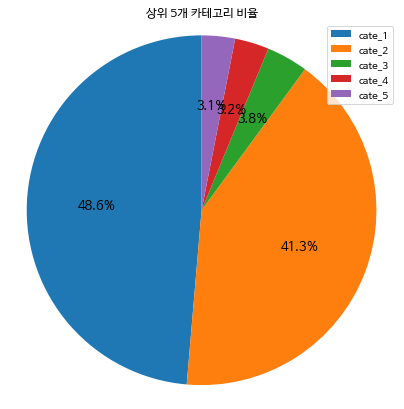

In [22]:
# 각 분기별 그래프
print('\n[16_4분기]')
PieChart_category(df_16_4_cate)

print('\n[17_1분기]')
PieChart_category(df_17_2_cate)

print('\n[17_2분기]')
PieChart_category(df_17_1_cate)

print('\n[17_3분기]')
PieChart_category(df_17_3_cate)

print('\n[17_4분기]')
PieChart_category(df_17_4_cate)

print('\n[18_1분기]')
PieChart_category(df_18_1_cate)

print('\n[18_2분기]')
PieChart_category(df_18_2_cate)

print('\n[18_3분기]')
PieChart_category(df_18_3_cate)

### 2. 산업별
- 판매자들의 산업 종류로는 Olist_closed_deals_data에 있는 lead_type을 활용해보았습니다. online_medium, online_bit, industry 등의 변수로 이루어져 있으며, 총 8개의 종류가 있습니다.
- 판매건수 별로 세기 위해서 df_order_items와 df_closed_deals를 병합(pk = seller_id)하였습니다.
- 분기별로 나누기위해 필요한 데이터인 날짜 데이터를 포함해 주기 위해 df_order와 다시 한번 병합(pk = order_id)하였습니다.
- 분기별로 산업군 별 판매'량'과 판매금액을 모두 보았으며, 판매 금액은 배송비 포함/미포함으로 나누어 보았습니다.

In [23]:
df_mql = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')
df_closed_deals = pd.read_csv('olist_closed_deals_dataset.csv')

In [25]:
# lead type의 종류
df_closed_deals['lead_type'].unique()

array(['online_medium', 'industry', 'online_big', 'online_small',
       'offline', 'online_top', 'online_beginner', 'other', nan],
      dtype=object)

In [58]:
# df_closed_deals와 df_order_items를 병합하기
df_for_leadtype_temp = pd.merge(df_order_items, df_closed_deals, how = 'inner', on = 'seller_id') # 양쪽 모두 있는 것으로 하기위해 inner
df_for_leadtype = pd.merge(df_for_leadtype_temp, df_orders, how = 'inner', on = 'order_id') # 양쪽 모두 있는 것으로 하기위해 inner

In [59]:
df_for_leadtype

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,mql_id,sdr_id,sr_id,...,business_type,declared_product_catalog_size,declared_monthly_revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40,cfccca319397a5ea2bb11bd90b0d925d,370c9f455f93a9a96cbe9bea48e70033,9e4d1098a3b0f5da39b0bc48f9876645,...,reseller,NaN,0.0,351d3cb2cee3c7fd0af6616c82df21d3,delivered,2018-07-02 13:59:39,2018-07-02 14:10:56,2018-07-03 14:25:00,2018-07-04 17:28:31,2018-07-23 00:00:00
1,01c1644529b18608f086d2ff0f3b8181,1,8b41f2becf919f6177cca1ff15dfd311,ba143b05f0110f0dc71ad71b4466ce92,2018-07-02 05:12:58,103.99,31.60,cfccca319397a5ea2bb11bd90b0d925d,370c9f455f93a9a96cbe9bea48e70033,9e4d1098a3b0f5da39b0bc48f9876645,...,reseller,NaN,0.0,3c90bb0fba16e889f898e2da1df5fb32,delivered,2018-06-23 09:55:44,2018-06-26 05:12:58,2018-06-26 14:25:00,2018-07-05 20:24:21,2018-08-01 00:00:00
2,034fe9142b806fe19c1cbc1c752ab08d,1,20fb650ad1615624d7e202031400f695,ba143b05f0110f0dc71ad71b4466ce92,2018-05-04 14:55:20,37.50,16.32,cfccca319397a5ea2bb11bd90b0d925d,370c9f455f93a9a96cbe9bea48e70033,9e4d1098a3b0f5da39b0bc48f9876645,...,reseller,NaN,0.0,9805ae32c145edf1ad0e8d8ab5e8fd8e,delivered,2018-04-28 14:44:05,2018-04-28 14:55:20,2018-05-02 09:23:00,2018-05-11 23:56:37,2018-05-18 00:00:00
3,03d6e874e44c091359a3ad62f2bec233,1,173e9fe34bfe97f3a5e6dc57fe897b74,ba143b05f0110f0dc71ad71b4466ce92,2018-05-10 03:12:07,57.49,11.15,cfccca319397a5ea2bb11bd90b0d925d,370c9f455f93a9a96cbe9bea48e70033,9e4d1098a3b0f5da39b0bc48f9876645,...,reseller,NaN,0.0,59d26debe9d60cc8467a7bf2b835959f,delivered,2018-05-02 13:42:27,2018-05-04 03:12:07,2018-05-07 14:52:00,2018-05-08 17:08:48,2018-05-14 00:00:00
4,07c33a9470d0df2a30cc8a8ebd0288d1,1,8ac47b3ab13c68f49f10dde899674149,ba143b05f0110f0dc71ad71b4466ce92,2018-05-23 05:16:30,83.99,11.21,cfccca319397a5ea2bb11bd90b0d925d,370c9f455f93a9a96cbe9bea48e70033,9e4d1098a3b0f5da39b0bc48f9876645,...,reseller,NaN,0.0,b4a2eabc4ac6b82d0f3aa2961fc9220b,delivered,2018-05-16 18:29:24,2018-05-18 05:16:30,2018-05-21 15:02:00,2018-05-23 14:58:36,2018-05-25 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,f8a9c0be5071e2ca36f561ad567b1800,1,6b966b123b31a54f73d652b5d8f45bb3,8b181ee5518df84f18f4e1a43fe07923,2018-06-05 09:31:39,27.90,27.08,e428d5580f729d23e6070e43c492e424,09285259593c61296eef10c734121d5b,de63de0d10a6012430098db33c679b0b,...,reseller,NaN,0.0,40e141d432fb1a06f862197c9c0de0ce,delivered,2018-05-30 09:21:06,2018-05-30 09:34:56,2018-06-05 12:19:00,2018-06-13 22:48:47,2018-07-05 00:00:00
5040,f94765982f45d2bae74c9cbf55d37387,1,94080f9219044d897195e2be145945dc,880ce4951cf857ab1d9e0b75c1d856f4,2018-02-19 20:15:32,178.90,18.82,512182619d12ae0863827b7e5ab97f19,de63de0d10a6012430098db33c679b0b,9ae085775a198122c5586fa830ff7f2b,...,reseller,NaN,0.0,fc1d80ada6741dcac4c20f6da659fb3e,delivered,2018-02-13 21:06:34,2018-02-13 21:15:32,2018-02-17 00:53:37,2018-02-28 22:13:03,2018-03-19 00:00:00
5041,fa8af66ee11f929d58f95e9a0522d792,1,0630f740d3f05c50f85d7dd7cffc60a3,cad10cc982ab6a391570c211b995c17c,2018-04-26 12:31:10,47.40,12.79,f2258c61a8b46c0620005f5949fb11b8,068066e24f0c643eb1d089c7dd20cd73,6565aa9ce3178a5caf6171827af3a9ba,...,reseller,NaN,0.0,a7361cef18d3fa0382cf9b7179c7de30,delivered,2018-04-22 12:03:21,2018-04-24 17:16:32,2018-04-23 18:32:27,2018-04-26 19:12:10,2018-05-10 00:00:00
5042,ff701a7c869ad21de22a6994237c8a00,1,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,17c77fd570aa86b74387fae66d9d4edd,de63de0d10a6012430098db33c679b0b,4ef15afb4b2723d8f3d81e51ec7afefe,...,reseller,NaN,0.0,8f6d16c31abb30b7b4650272cb0014a3,delivered,2018-04-12 19:47:40,2018-04-12 20:10:33,2018-04-18 00:41:29,2018-04-20 17:48:39,2

In [95]:
mask_16_4 = (df_for_leadtype['order_estimated_delivery_date'] > '2016-10-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2016-12-31')
mask_17_1 = (df_for_leadtype['order_estimated_delivery_date'] > '2017-01-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2017-03-31')
mask_17_2 = (df_for_leadtype['order_estimated_delivery_date'] > '2017-04-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2017-06-31')
mask_17_3 = (df_for_leadtype['order_estimated_delivery_date'] > '2017-07-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2017-09-31')
mask_17_4 = (df_for_leadtype['order_estimated_delivery_date'] > '2017-10-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2017-12-31')
mask_18_1 = (df_for_leadtype['order_estimated_delivery_date'] > '2018-01-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2018-03-31')
mask_18_2 = (df_for_leadtype['order_estimated_delivery_date'] > '2018-04-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2018-06-31')
mask_18_3 = (df_for_leadtype['order_estimated_delivery_date'] > '2018-06-01') & (df_for_leadtype['order_estimated_delivery_date'] <= '2018-06-31')

In [96]:
# 분기 필터 적용
df_16_4_leadtype = df_for_leadtype.loc[mask_16_4]
df_17_1_leadtype = df_for_leadtype.loc[mask_17_1]
df_17_2_leadtype = df_for_leadtype.loc[mask_17_2]
df_17_3_leadtype = df_for_leadtype.loc[mask_17_3]
df_17_4_leadtype = df_for_leadtype.loc[mask_17_4]
df_18_1_leadtype = df_for_leadtype.loc[mask_18_1]
df_18_2_leadtype = df_for_leadtype.loc[mask_18_2]
df_18_3_leadtype = df_for_leadtype.loc[mask_18_3]

In [99]:
df_17_4_leadtype

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,mql_id,sdr_id,sr_id,...,business_type,declared_product_catalog_size,declared_monthly_revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


- 18_1분기 부터 산업군을 식별해서 데이터를 나누기 시작한 것으로 보입니다. 합병 전에는 18_1분기 이전의 데이터도 있겠지만, 합병 후 남아있어야 사용할 수 있기에, 18_1분기 이전 데이터는 제외한 후 진행하였습니다.

#### 2.1 판매'량'

In [100]:
def cnt_leadtype(df):
  # 산업별 판매'량'
  df_cnt = pd.DataFrame(df['lead_type'].value_counts())

  # 컬럼 명 바꿔주기 (cnt로)
  df_cnt.rename(columns = {'lead_type':'cnt'}, inplace = True)

  # 데이터프레임 인덱스 정리
  df_cnt = df_cnt.reset_index()


  # 그래프 그리기
  # 모든 카테고리 그래프
  labels = df_cnt['index']

  fig = plt.figure(figsize=(7,7)) ## 캔버스 생성
  fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
  ax = fig.add_subplot() ## 프레임 생성

  pie = ax.pie(df_cnt['cnt'], 
              startangle = 90, 
              autopct = '%1.1f%%',
              # explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
              textprops = {'size' : 13})
  plt.axis('equal')
  plt.legend(pie[0],labels, loc='upper left')
  plt.title('산업별 판매량 비율')
  plt.show()

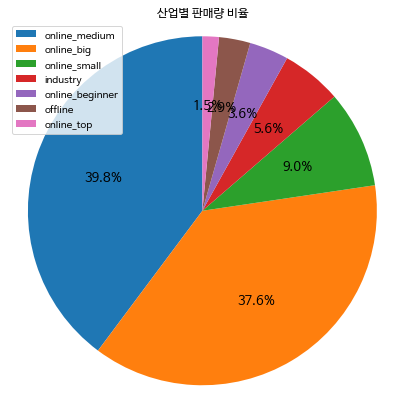

In [101]:
# 전체 산업별 판매'량' 비율
cnt_leadtype(df_for_leadtype)

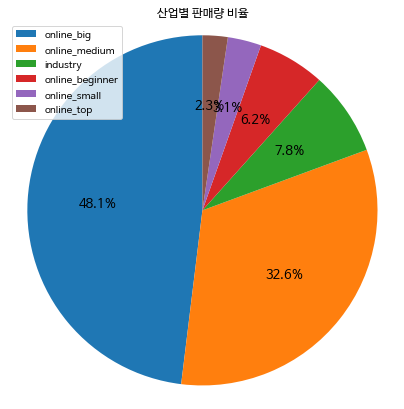

In [106]:
# 18_1분기
cnt_leadtype(df_18_1_leadtype)

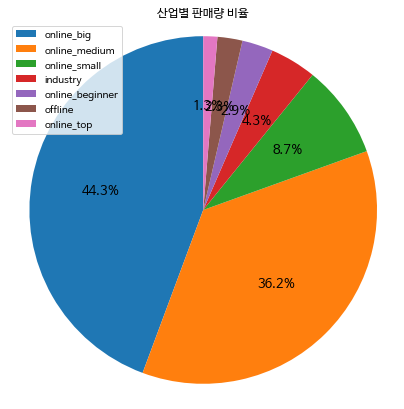

In [102]:
# 18_2분기
cnt_leadtype(df_18_2_leadtype)

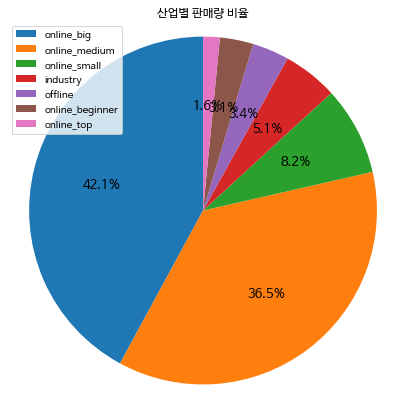

In [107]:
# 18_3분기
cnt_leadtype(df_18_3_leadtype)

#### 2.2 판매금액(배송비 미포함)

In [103]:
def BarChart_volume_revenue_leadtype(df): # 산업에 따른 판매 규모
  # 산업별 판매규모 구하기 (배송비 미포함)
  df_revenue = pd.DataFrame(df.groupby('lead_type')['price'].sum())
  df_revenue.reset_index(inplace = True)

  # 그래프에 똑같은 순서로 나올 수 있도록 정렬
  df_revenue = df_revenue.sort_values('lead_type')

  df_revenue.plot.bar(x = 'lead_type', y = 'price', title="산업별 판매규모", rot = 45, fontsize=12, figsize=(10,5))

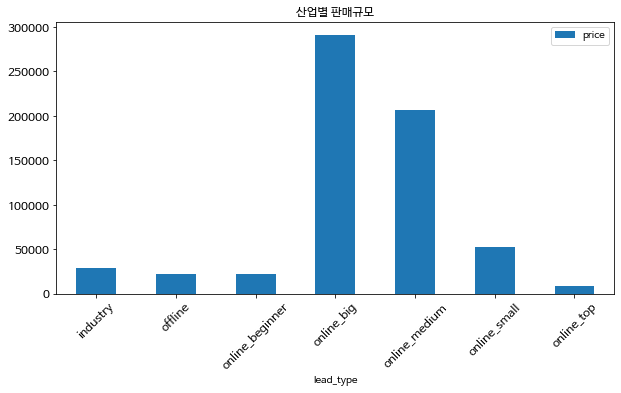

In [104]:
# 전체분기의 산업별 판매 규모
BarChart_volume_revenue_leadtype(df_for_leadtype)


[18_1분기]

[18_2분기]

[18_3분기]


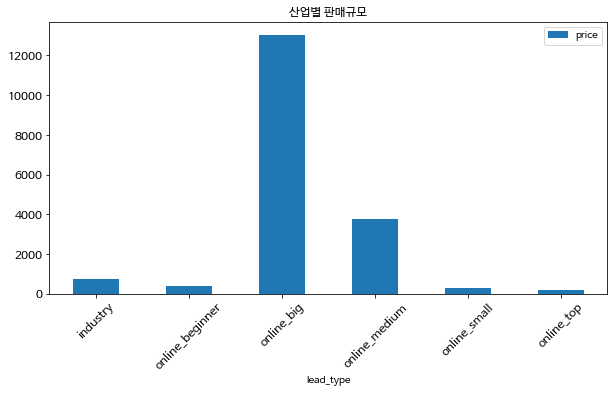

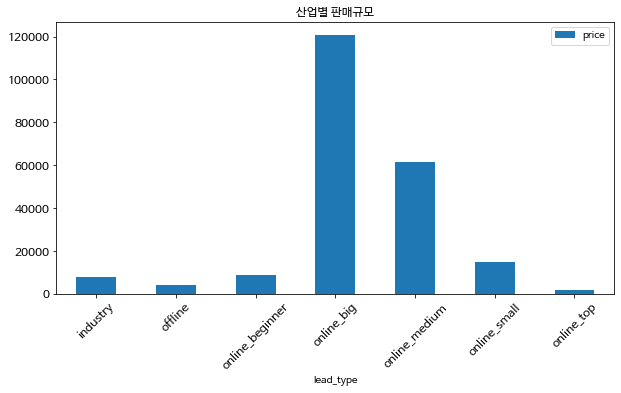

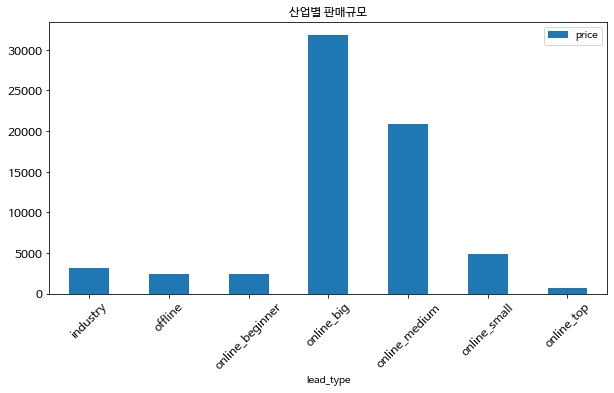

In [105]:
# 각 분기별 그래프

print('\n[18_1분기]')
BarChart_volume_revenue_leadtype(df_18_1_leadtype)

print('\n[18_2분기]')
BarChart_volume_revenue_leadtype(df_18_2_leadtype)

print('\n[18_3분기]')
BarChart_volume_revenue_leadtype(df_18_3_leadtype)

- offline 산업이 새로 18_2분기에 진입했지만, 판매금액은 큰 편이 아닙니다.
- 전체적인 산업별 동향은 분기마다 비슷한 것을 볼 수 있습니다.